In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import signal
from torch.utils.tensorboard import SummaryWriter

In [2]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Trading_bot_1')

In [3]:
goog = pd.read_csv('GOOG.csv')

In [4]:
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400
...,...,...,...,...,...,...,...
1756,2017-08-03,949.099976,950.000000,939.440002,940.299988,940.299988,1123900
1757,2017-08-04,943.950012,947.539978,939.799988,945.789978,945.789978,1254600
1758,2017-08-07,947.520020,948.960022,943.500000,945.750000,945.750000,1445800
1759,2017-08-08,944.289978,952.489990,942.479980,944.190002,944.190002,1505100


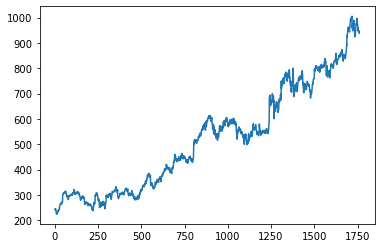

In [5]:
plt.plot(range(0, len(goog.Open)), goog.Open)

In [6]:
goog_open= goog["Open"].values
goog_close = goog["Close"].values

In [7]:
class TradingEnvironment():
    def __init__(self, data_open = goog_open, data_close = goog_close, series_length=200, starting_point=0):
        
        self.data_open = data_open
        self.data_close = data_close
        #Observation space [No.of shares, Cash in hand, next opening price, portfolio value, past 5 day average]
        self.state = torch.FloatTensor(torch.zeros(5))
        #Starting cash
        self.starting_cash = 6000
        #Length of time series
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        #Initial No.of shares
        self.state[0] = 20
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        #Inventory holds the price of bought stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])

        self.done = False
        self.profit = 0
        
    def portfolio_value(self):#To calculate total portfolio value
        return (self.state[0] * self.data_close[self.cur_timestep]) + self.state[1]
    
    def next_opening_price(self):#Finding the next opening price
        step = self.cur_timestep + 1
        return self.data_open[step]
    
    def five_day_window(self):#past Five day average calc
        step = self.cur_timestep
        if step < 5:
            return self.data_open[0]
        goog5 = self.data_open[step-5:step].mean()
        return goog5
    
    def step(self, action):
        delta = 0
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        retval = None
        cur_value = self.portfolio_value()
        
        #Check if done
        if cur_timestep >= self.starting_point + (self.series_length):
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            if self.profit > 0:
                rew = 1
            else:
                rew = 0
            return new_state, rew, True, { "msg": "done"}
        #action ==2 ,Do nothing return the next state
        if action[0] == 2:
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            retval = new_state, 0, False, { "msg": "nothing" }
             
        #Action = 0, Buy, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 0:
            if action[1] * self.data_open[cur_timestep] < self.state[1]:
                goog_shares = self.state[0] + action[1]
                cash_spent = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1]- cash_spent, self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory[-1]
                delt = prev_price - self.data_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory.append(self.data_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought goog"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 1: #Action = 1, Sell, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[0]:
                goog_shares = self.state[0] - action[1]
                cash_gained = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1] + cash_gained, self.next_opening_price(), cur_value, self.five_day_window()]
                bought_price = self.inventory.pop(0)
                delta = self.data_open[cur_timestep] - bought_price
                self.state = new_state
                if delta > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold goog"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        #Calculate selling profit      
        self.profit += delta
        #Increase step
        self.cur_timestep += 1
        return retval
    
    def reset(self):#Reset observation space and timestep
        self.state = torch.FloatTensor(torch.zeros(5))
        self.starting_cash = 6000
        self.cur_timestep = self.starting_point
        self.state[0] = 20
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        self.done = False
        self.inventory = []
        num = int(self.state[0].item())
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
        self.profit = 0

        return self.state

In [8]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(5, 128)
        self.hidden_1 = nn.Linear(128, 32)
        self.hidden_2 = nn.Linear(32,31)
        #Actor Layer
        self.action_head = nn.Linear(31, 3)
        #Critic Layer
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        #Get an action
        action = m.sample()
        #If action is sell and no.of share is zero, force it to do nothing
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [9]:
#Define Environment, Agent, optimizer
env = TradingEnvironment(data_open = goog_open, data_close = goog_close, series_length= len(goog_open)-2)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [10]:
env.reset()
gamma = 0.988
#Log every 50 episode
log_interval = 100

#At the end of each episode update gardients
def finish_episode(episode):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []
    #Calculate discounted reward
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        returns.insert(0, R)
        
    returns = torch.tensor(returns)

    #Standardize the discounted reward (Helps converge faster)
    eps = np.finfo(np.float32).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)

    #Calculate policy and value loss  
    for (log_prob, value), R in zip(saved_actions, returns):
        #Calculate advantage value
        advantage = torch.tensor(R - value.item())
        policy_losses.append(-log_prob * advantage)
        #Smooth L1 loss has the advantage of both L1 and L2 loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    #Reset gradients           
    optimizer.zero_grad()
    #Sum up policy and value losses
    loss = torch.stack(policy_losses).mean() + torch.stack(value_losses).mean()
    writer.add_scalar('Policy loss',torch.stack(policy_losses).mean(), episode)
    writer.add_scalar('Value loss',torch.stack(value_losses).mean(), episode)
    writer.add_scalar('Total loss',loss, episode)
    #Backpropogation
    loss.backward()
    optimizer.step()    
    #Delete saved rewards and actions
    del model.rewards[:]
    del model.saved_actions[:]

In [11]:
#Start training
running_reward = 100
#Train for 1000 episodes
for episode in range(0,2000):
    state = env.reset()
    done = False
    msg = None
    ep_rew = 0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        #print(action,state,reward)
        model.rewards.append(reward)
        ep_rew += reward
        if done:
            break
    finish_episode(episode)
    running_reward = running_reward * (1 - 0.05) + ep_rew * (0.05)
     # ...log the running reward
    writer.add_scalar('Running reward',running_reward,episode)
    #stop training if the threshold is reached
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and reward == 1 and running_reward > 950:
        print("Early Stopping--- Profit :" + str(int(env.profit)))
        break
    #Log every 10 episodes
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, last reward {} \
episode reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, ep_rew, running_reward))

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 10925.0, finished at 11413.4 because Bankrupt @ t=253, last reward 0 episode reward 75.0, running reward 98.8
Episode 100: started at 10925.0, finished at 12370.6 because Bankrupt @ t=313, last reward 0 episode reward 90.0, running reward 238.9
Episode 200: started at 10925.0, finished at 11835.6 because Sold more than have @ t=468, last reward 0 episode reward 152.0, running reward 316.4
Episode 300: started at 10925.0, finished at 17893.8 because Bankrupt @ t=990, last reward 0 episode reward 390.0, running reward 463.8
Episode 400: started at 10925.0, finished at 24673.0 because done @ t=1759, last reward 1 episode reward 781.0, running reward 652.2
Episode 500: started at 10925.0, finished at 20628.6 because Sold more than have @ t=1608, last reward 0 episode reward 802.0, running reward 793.6
Episode 600: started at 10925.0, finished at 21506.7 because done @ t=1759, last reward 1 episode reward 871.0, running reward 868.4
Episode 700: started at 10925.0, fin

In [12]:
#Check out a sample run
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} shares, cash in hand is {} ".format(msg["msg"], next_state[0], next_state[1]))
    if msg["msg"] == "done":
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 10925.025390625
bought goog, have 21.0 shares, cash in hand is 5757.78759765625 
bought goog, have 22.0 shares, cash in hand is 5513.04296875 
sold goog, have 21.0 shares, cash in hand is 5755.125 
sold goog, have 20.0 shares, cash in hand is 5999.63427734375 
sold goog, have 19.0 shares, cash in hand is 6245.099609375 
sold goog, have 18.0 shares, cash in hand is 6485.84521484375 
bought goog, have 19.0 shares, cash in hand is 6251.6259765625 
bought goog, have 20.0 shares, cash in hand is 6020.64501953125 
sold goog, have 19.0 shares, cash in hand is 6249.72412109375 
sold goog, have 18.0 shares, cash in hand is 6474.94921875 
bought goog, have 19.0 shares, cash in hand is 6246.69091796875 
sold goog, have 18.0 shares, cash in hand is 6473.197265625 
bought goog, have 19.0 shares, cash in hand is 6243.392578125 
sold goog, have 18.0 shares, cash in hand is 6468.6728515625 
sold goog, have 17.0 shares, cash in hand is 6696.390625 
sold goog, have 16.0 shares, 

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app



bought goog, have 20.0 shares, cash in hand is 5544.3876953125 
sold goog, have 19.0 shares, cash in hand is 5856.28955078125 
sold goog, have 18.0 shares, cash in hand is 6168.61181640625 
bought goog, have 19.0 shares, cash in hand is 5853.29638671875 
bought goog, have 20.0 shares, cash in hand is 5541.94482421875 
bought goog, have 21.0 shares, cash in hand is 5231.78466796875 
sold goog, have 20.0 shares, cash in hand is 5539.0869140625 
bought goog, have 21.0 shares, cash in hand is 5237.2451171875 
sold goog, have 20.0 shares, cash in hand is 5533.921875 
sold goog, have 19.0 shares, cash in hand is 5826.71484375 
sold goog, have 18.0 shares, cash in hand is 6121.509765625 
sold goog, have 17.0 shares, cash in hand is 6420.30859375 
sold goog, have 16.0 shares, cash in hand is 6714.33740234375 
sold goog, have 15.0 shares, cash in hand is 7008.13623046875 
sold goog, have 14.0 shares, cash in hand is 7302.0849609375 
bought goog, have 15.0 shares, cash in hand is 7006.559570312

#### Testing on Google_2019 dataset

In [13]:
#Load test dataset
te_goog = pd.read_csv('GOOG_2019.csv')

In [14]:
te_goog.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [15]:
te_goog.Date = pd.to_datetime(te_goog.Date)

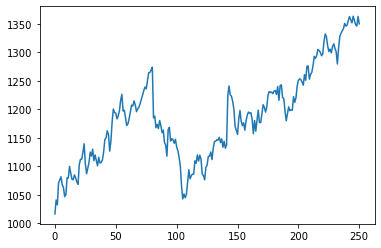

In [16]:
plt.plot(range(0,len( te_goog.Open)),  te_goog.Open)

In [17]:
env_test = TradingEnvironment(data_open=te_goog.Open, data_close = te_goog.Close, series_length=len(te_goog.Close)-2)
env_test.reset()
state = env_test.reset()
reward = 0
done = False
msg = None
bought_goog_at = []
sold_goog_at = []
bg_action_times = []
sg_action_times = []
n_action_times = []
nothing_at = []
print('Starting Portfolio value :',env_test.portfolio_value().item())
while not done:
    action = model.act(state)
    if action == 0:
        bought_goog_at.append(te_goog.Open[env_test.cur_timestep])
        bg_action_times.append(env_test.cur_timestep)
    if action == 1:
        sold_goog_at.append(te_goog.Open[env_test.cur_timestep])
        sg_action_times.append(env_test.cur_timestep)
    if action == 2:
        nothing_at.append(1000)
        n_action_times.append(env_test.cur_timestep)
    state, reward, done, msg = env_test.step(action)
    model.rewards.append(reward)
if msg["msg"] == "done":
        print("Have {} shares and ${} cash. selling profit: {}, Total portfolio value: {}".format(state[0], state[1],env_test.profit, env_test.portfolio_value()))
    

Starting Portfolio value : 26917.0


C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Have 7.0 shares and $21055.2734375 cash. selling profit: 4155.4844410000005, Total portfolio value: 30518.50390625


In [18]:
buy_date = [te_goog.Date[x] for x in bg_action_times]
sell_date = [te_goog.Date[x] for x in sg_action_times]

In [35]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(te_goog, x='Date', y='Open')
fig.add_trace(go.Scatter(x = buy_date,y = bought_goog_at, mode="markers",showlegend=True,name="Buy"))
fig.add_trace(go.Scatter(x = sell_date,y = sold_goog_at, mode="markers",showlegend=True,name="Sell"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title="AC Test results on Goog_2019 with selliong profit :" + str(env_test.profit.round()) + ', end portfolio value :' +str(env_test.portfolio_value().item()))
fig.show()